# Generative Adversarial Network

## Pre-processing data

In [37]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
tf.reset_default_graph()

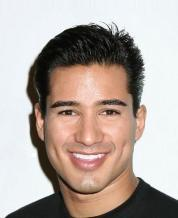

In [38]:
Image("img_align_celeba/000214.jpg") 

In [39]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
data_size = 25001
def get_data(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
    
def get_data_normalized(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)/256.0
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
        
def get_batch(batch_size, dataset):
        indexes = np.random.randint(0, len(dataset), batch_size)
        data = dataset[indexes]
        return data

def sample_Z(batch_size=50, n=100):
        return np.random.uniform(-1., 1., size=[batch_size, n])

Data loaded. Number of images: 5
[[[0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  ...
  [0.9609375  0.890625   0.84375   ]
  [0.99609375 0.92578125 0.87109375]
  [0.9921875  0.9296875  0.8671875 ]]

 [[0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  ...
  [0.96875    0.8984375  0.8515625 ]
  [0.99609375 0.92578125 0.87109375]
  [0.9921875  0.9296875  0.8671875 ]]

 [[0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  [0.98828125 0.90234375 0.7578125 ]
  ...
  [0.9765625  0.90625    0.859375  ]
  [0.99609375 0.9296875  0.875     ]
  [0.99609375 0.93359375 0.87109375]]

 ...

 [[0.546875   0.2890625  0.1015625 ]
  [0.44921875 0.19140625 0.00390625]
  [0.5703125  0.3046875  0.12890625]
  ...
  [0.4765625  0.21484375 0.109375  ]
  [0.48046875 0.21875    0.1171875 ]
  [0.4765625  0.21875    0.1171875 ]]

 [[0.5078125  0.2421875  0.05859375]
  [0

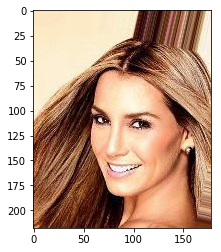

In [40]:
dat = get_data_normalized(5)
print(dat[0])
plt.imshow(dat[0])

In [41]:
def generator_mlp(Z, fc_sizes=[110,200,300], output_dim=218*178*3, reuse=False):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        fc1 = tf.layers.dense(Z, fc_sizes[0], activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(fc1, fc_sizes[1], activation=tf.nn.leaky_relu)
        fc3 = tf.layers.dense(fc2, fc_sizes[2], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(fc3, output_dim)
        out = tf.reshape(out, shape=(tf.shape(out)[0],218,178,3))
    return out


In [42]:
def discriminator_cnn(X, fc_sizes=[110,300,200], reuse=False, alpha=0.2, keep_prob=0.5):
    
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        # Input layer is 218x178x3
        # Convolutional layer, 109x89x64
        conv1 = tf.layers.conv2d(X, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        # Strided convolutional layer, 55x45x128
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        # Strided convolutional layer, 28x23x256
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        # fully connected
        flat = tf.reshape(drop3, (-1, 28*23*256))
        out = tf.layers.dense(flat, 1)
        
        return out

In [43]:
X = tf.placeholder(tf.float32,[None,218,178,3])
XX = tf.reshape(X, shape=(tf.shape(X)[0], 218*178*3))
Z = tf.placeholder(tf.float32,[None,100])

In [44]:
G_sample = generator_mlp(Z)

In [45]:
r_logits = discriminator_cnn(X)
f_logits = discriminator_cnn(G_sample, reuse=True)

In [46]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


In [47]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


Data loaded. Number of images: 1000
Iterations: 0	 Discriminator loss: 1.3564	 Generator loss: 0.6918
Iterations: 1	 Discriminator loss: 1.3112	 Generator loss: 0.6915
Iterations: 2	 Discriminator loss: 1.2622	 Generator loss: 0.6913
Iterations: 3	 Discriminator loss: 1.2300	 Generator loss: 0.6907
Iterations: 4	 Discriminator loss: 1.1848	 Generator loss: 0.6907
Iterations: 5	 Discriminator loss: 1.1356	 Generator loss: 0.6902
Iterations: 6	 Discriminator loss: 1.0926	 Generator loss: 0.6905
Iterations: 7	 Discriminator loss: 1.0358	 Generator loss: 0.6906
Iterations: 8	 Discriminator loss: 1.0094	 Generator loss: 0.6902
Iterations: 9	 Discriminator loss: 0.9835	 Generator loss: 0.6913
Iterations: 10	 Discriminator loss: 0.9578	 Generator loss: 0.6909
Iterations: 11	 Discriminator loss: 0.9188	 Generator loss: 0.6926
Iterations: 12	 Discriminator loss: 0.8803	 Generator loss: 0.6937
Iterations: 13	 Discriminator loss: 0.8865	 Generator loss: 0.6955
Iterations: 14	 Discriminator loss: 

Iterations: 122	 Discriminator loss: 0.8202	 Generator loss: 2.4983
Iterations: 123	 Discriminator loss: 0.4083	 Generator loss: 2.0286
Iterations: 124	 Discriminator loss: 0.5517	 Generator loss: 2.9670
Iterations: 125	 Discriminator loss: 1.6290	 Generator loss: 0.1053
Iterations: 126	 Discriminator loss: 6.2330	 Generator loss: 2.5180
Iterations: 127	 Discriminator loss: 2.0913	 Generator loss: 0.6384
Iterations: 128	 Discriminator loss: 1.6265	 Generator loss: 1.1151
Iterations: 129	 Discriminator loss: 1.2658	 Generator loss: 1.1132
Iterations: 130	 Discriminator loss: 1.1051	 Generator loss: 1.5353
Iterations: 131	 Discriminator loss: 1.6253	 Generator loss: 0.7868
Iterations: 132	 Discriminator loss: 1.5196	 Generator loss: 3.5265
Iterations: 133	 Discriminator loss: 3.1652	 Generator loss: 0.4157
Iterations: 134	 Discriminator loss: 2.3588	 Generator loss: 1.4441
Iterations: 135	 Discriminator loss: 1.2768	 Generator loss: 0.8340
Iterations: 136	 Discriminator loss: 1.4140	 Gen

Iterations: 244	 Discriminator loss: 1.2570	 Generator loss: 0.8402
Iterations: 245	 Discriminator loss: 1.2717	 Generator loss: 0.8433
Iterations: 246	 Discriminator loss: 1.3185	 Generator loss: 1.3569
Iterations: 247	 Discriminator loss: 1.0959	 Generator loss: 0.7544
Iterations: 248	 Discriminator loss: 3.0479	 Generator loss: 2.9271
Iterations: 249	 Discriminator loss: 2.4736	 Generator loss: 0.1370
Iterations: 250	 Discriminator loss: 2.3554	 Generator loss: 1.1813
Iterations: 251	 Discriminator loss: 1.4911	 Generator loss: 0.7757
Iterations: 252	 Discriminator loss: 1.4375	 Generator loss: 0.9534
Iterations: 253	 Discriminator loss: 1.3358	 Generator loss: 0.7093
Iterations: 254	 Discriminator loss: 1.3231	 Generator loss: 1.1389
Iterations: 255	 Discriminator loss: 1.1828	 Generator loss: 0.6857
Iterations: 256	 Discriminator loss: 1.1074	 Generator loss: 1.7556
Iterations: 257	 Discriminator loss: 1.1761	 Generator loss: 0.7689
Iterations: 258	 Discriminator loss: 1.0507	 Gen

Iterations: 366	 Discriminator loss: 1.0600	 Generator loss: 1.0022
Iterations: 367	 Discriminator loss: 1.2318	 Generator loss: 1.0485
Iterations: 368	 Discriminator loss: 1.0916	 Generator loss: 1.4728
Iterations: 369	 Discriminator loss: 1.0995	 Generator loss: 0.7414
Iterations: 370	 Discriminator loss: 1.0158	 Generator loss: 2.0245
Iterations: 371	 Discriminator loss: 0.7850	 Generator loss: 0.6965
Iterations: 372	 Discriminator loss: 3.6479	 Generator loss: 1.7893
Iterations: 373	 Discriminator loss: 3.6372	 Generator loss: 1.3515
Iterations: 374	 Discriminator loss: 2.1003	 Generator loss: 3.4964
Iterations: 375	 Discriminator loss: 3.1056	 Generator loss: 0.0732
Iterations: 376	 Discriminator loss: 2.6986	 Generator loss: 1.1728
Iterations: 377	 Discriminator loss: 1.5832	 Generator loss: 0.7437
Iterations: 378	 Discriminator loss: 1.2215	 Generator loss: 0.8249
Iterations: 379	 Discriminator loss: 1.1564	 Generator loss: 0.7516
Iterations: 380	 Discriminator loss: 1.2399	 Gen

Iterations: 488	 Discriminator loss: 1.4149	 Generator loss: 0.7406
Iterations: 489	 Discriminator loss: 1.2915	 Generator loss: 0.6852
Iterations: 490	 Discriminator loss: 1.2824	 Generator loss: 1.1194
Iterations: 491	 Discriminator loss: 1.2392	 Generator loss: 0.5941
Iterations: 492	 Discriminator loss: 1.6780	 Generator loss: 1.8692
Iterations: 493	 Discriminator loss: 1.5811	 Generator loss: 0.5286
Iterations: 494	 Discriminator loss: 1.3989	 Generator loss: 1.0488
Iterations: 495	 Discriminator loss: 1.3192	 Generator loss: 1.0091
Iterations: 496	 Discriminator loss: 1.1960	 Generator loss: 1.1810
Iterations: 497	 Discriminator loss: 1.2479	 Generator loss: 0.5805
Iterations: 498	 Discriminator loss: 1.8042	 Generator loss: 3.3794
Iterations: 499	 Discriminator loss: 3.0851	 Generator loss: 0.0784
Iterations: 500	 Discriminator loss: 4.4100	 Generator loss: 43.6692
Iterations: 501	 Discriminator loss: 54.2673	 Generator loss: 1.2084
Iterations: 502	 Discriminator loss: 3.8426	 G

Iterations: 610	 Discriminator loss: 1.4025	 Generator loss: 0.7832
Iterations: 611	 Discriminator loss: 1.3200	 Generator loss: 0.5190
Iterations: 612	 Discriminator loss: 1.6273	 Generator loss: 1.9753
Iterations: 613	 Discriminator loss: 2.0612	 Generator loss: 0.6086
Iterations: 614	 Discriminator loss: 1.4894	 Generator loss: 0.8117
Iterations: 615	 Discriminator loss: 1.3631	 Generator loss: 0.7096
Iterations: 616	 Discriminator loss: 1.3636	 Generator loss: 0.7224
Iterations: 617	 Discriminator loss: 1.3239	 Generator loss: 0.8283
Iterations: 618	 Discriminator loss: 1.2162	 Generator loss: 1.1776
Iterations: 619	 Discriminator loss: 1.4736	 Generator loss: 0.3681
Iterations: 620	 Discriminator loss: 1.9094	 Generator loss: 1.3286
Iterations: 621	 Discriminator loss: 1.6079	 Generator loss: 0.5944
Iterations: 622	 Discriminator loss: 1.3895	 Generator loss: 1.6590
Iterations: 623	 Discriminator loss: 1.9453	 Generator loss: 0.5755
Iterations: 624	 Discriminator loss: 1.4089	 Gen

Iterations: 732	 Discriminator loss: 1.3613	 Generator loss: 1.3892
Iterations: 733	 Discriminator loss: 1.1743	 Generator loss: 0.6759
Iterations: 734	 Discriminator loss: 1.5308	 Generator loss: 4.0269
Iterations: 735	 Discriminator loss: 2.9277	 Generator loss: 0.1974
Iterations: 736	 Discriminator loss: 2.3773	 Generator loss: 1.4400
Iterations: 737	 Discriminator loss: 1.5222	 Generator loss: 0.6519
Iterations: 738	 Discriminator loss: 1.3437	 Generator loss: 1.3066
Iterations: 739	 Discriminator loss: 1.4332	 Generator loss: 0.6672
Iterations: 740	 Discriminator loss: 1.8188	 Generator loss: 1.1297
Iterations: 741	 Discriminator loss: 1.3056	 Generator loss: 0.7869
Iterations: 742	 Discriminator loss: 1.4597	 Generator loss: 0.7824
Iterations: 743	 Discriminator loss: 1.3770	 Generator loss: 1.0993
Iterations: 744	 Discriminator loss: 1.2363	 Generator loss: 0.7730
Iterations: 745	 Discriminator loss: 1.2826	 Generator loss: 1.0120
Iterations: 746	 Discriminator loss: 1.2821	 Gen

Iterations: 854	 Discriminator loss: 1.3582	 Generator loss: 1.3341
Iterations: 855	 Discriminator loss: 1.3018	 Generator loss: 6.7875
Iterations: 856	 Discriminator loss: 2.8470	 Generator loss: 0.6197
Iterations: 857	 Discriminator loss: 1.7152	 Generator loss: 1.1081
Iterations: 858	 Discriminator loss: 1.3714	 Generator loss: 0.6824
Iterations: 859	 Discriminator loss: 1.1109	 Generator loss: 1.1318
Iterations: 860	 Discriminator loss: 1.2930	 Generator loss: 2.0390
Iterations: 861	 Discriminator loss: 1.6852	 Generator loss: 0.3531
Iterations: 862	 Discriminator loss: 1.9086	 Generator loss: 1.5296
Iterations: 863	 Discriminator loss: 1.4478	 Generator loss: 0.7003
Iterations: 864	 Discriminator loss: 1.6377	 Generator loss: 1.2151
Iterations: 865	 Discriminator loss: 1.3460	 Generator loss: 0.6876
Iterations: 866	 Discriminator loss: 1.6607	 Generator loss: 1.3035
Iterations: 867	 Discriminator loss: 1.4147	 Generator loss: 0.3867
Iterations: 868	 Discriminator loss: 1.8383	 Gen

Iterations: 976	 Discriminator loss: 1.8417	 Generator loss: 0.5952
Iterations: 977	 Discriminator loss: 1.4135	 Generator loss: 0.9331
Iterations: 978	 Discriminator loss: 1.5972	 Generator loss: 1.0983
Iterations: 979	 Discriminator loss: 1.3187	 Generator loss: 0.6587
Iterations: 980	 Discriminator loss: 1.7274	 Generator loss: 1.9786
Iterations: 981	 Discriminator loss: 1.8589	 Generator loss: 0.8395
Iterations: 982	 Discriminator loss: 1.4350	 Generator loss: 0.8744
Iterations: 983	 Discriminator loss: 1.3713	 Generator loss: 1.4314
Iterations: 984	 Discriminator loss: 0.9321	 Generator loss: 1.5152
Iterations: 985	 Discriminator loss: 1.5765	 Generator loss: 2.5730
Iterations: 986	 Discriminator loss: 1.8598	 Generator loss: 0.5505
Iterations: 987	 Discriminator loss: 1.3511	 Generator loss: 1.3202
Iterations: 988	 Discriminator loss: 1.2302	 Generator loss: 0.9092
Iterations: 989	 Discriminator loss: 1.0779	 Generator loss: 1.2498
Iterations: 990	 Discriminator loss: 1.1564	 Gen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


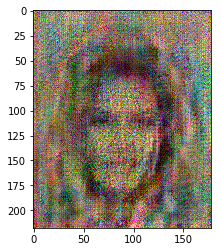

In [48]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 10
nd_steps = 10
ng_steps = 10
dataset = get_data_normalized(1000)

for i in range(1000):
    X_batch = get_batch(batch_size, dataset)
    Z_batch = sample_Z(batch_size, 100)
    _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


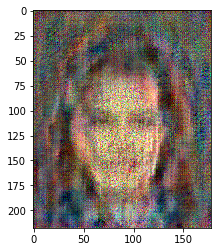

In [49]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


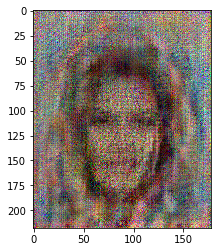

In [50]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


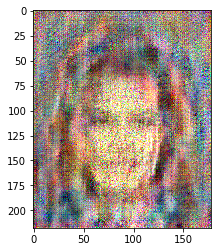

In [51]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))